In [1]:
from ema_workbench import Model, MultiprocessingEvaluator, Policy, Scenario

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import pairs_plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim

from ema_workbench.analysis import feature_scoring

In [2]:
if __name__ == "__main__":
    model, _ = get_model_for_problem_formulation(4)

    with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
        results = evaluator.perform_experiments(scenarios=100, policies=3)

100%|████████████████████████████████████████| 300/300 [00:13<00:00, 22.52it/s]


In [3]:
def get_do_nothing_dict():
    return {l.name: 0 for l in model.levers}


policies = [
    #Policy 1:
    #Activates all RfR projects early
    #Minimal dike heightening
    # Moderate early warning: proactive but not alarmist
    # Why it fits Veluwe:
        # Maximum ecological value
        # Slows discharge and improves water retention
        # Avoids heavy infrastructure
    Policy("policy 1- nature_based_low_dikes",**dict(
            get_do_nothing_dict(),
            ** { "1_RfR 0": 1,
    "2_RfR 0": 1,
    "3_RfR 0": 1,
    "4_RfR 0": 1,
    "5_RfR 0": 1,
    "Deventer_DikeIncrease 0": 2,
    "Zutphen_DikeIncrease 0": 1,
    "EWS_DaysToThreat": 3
})),
    #Policy 2:
    #Selective RfR implementation
    #No dike upgrades
    #Strong reliance on early evacuation (4 days notice)
    #Why it fits Veluwe:
        #Low-cost, low-impact strategy
        #Reflects a smart, adaptive mindset
        #Ideal for short-term results and ecological preservatio
    Policy("policy 2- minimalist_smart_response",**dict(
            get_do_nothing_dict(),
            ** {
    "1_RfR 0": 0, "2_RfR 0": 1, "3_RfR 0": 0, "4_RfR 0": 1, "5_RfR 0": 0,
    "Deventer_DikeIncrease 0": 0,
    "Zutphen_DikeIncrease 0": 0,
    "EWS_DaysToThreat": 4
})),
    #Policy 3:
    #Mix of nature-based and structural measures
    # Moderate dike increases in high-risk areas
    # Medium warning time
    #Why it fits Veluwe:
    #Balanced, politically acceptable
    # Useful if full ecological strategy is not feasible
    Policy("policy 3- balanced_hybrid_policy",**dict(
            get_do_nothing_dict(),
            **  {
    "1_RfR 0": 1, "2_RfR 0": 1, "3_RfR 0": 0, "4_RfR 0": 0, "5_RfR 0": 1,
    "Deventer_DikeIncrease 0": 4,
    "Zutphen_DikeIncrease 0": 3,
    "EWS_DaysToThreat": 2
})),
    #Policy 4:
    #Strategic mix of RfR and moderate dike strengthening
    # Flexible and diversified approach
    # Early warning is balanced
    #Why it fits Veluwe:
        # Long-term climate resilience
        # Embraces uncertainty and variability
        # A compromise between robustness and sustainability
     Policy("policy 4- climate_adaptive_policy",**dict(
            get_do_nothing_dict(),
            **  {
    "1_RfR 0": 1, "2_RfR 0": 0, "3_RfR 0": 1, "4_RfR 0": 0, "5_RfR 0": 1,
    "Deventer_DikeIncrease 0": 3,
    "Zutphen_DikeIncrease 0": 5,
    "EWS_DaysToThreat": 3
})),
    #Policy 5 - doesn't fit the veluwe
    #Maximal dike reinforcement
    #No RfR investment
    #Late early warning (reactive strategy)
    #Why it doesn’t fit Veluwe:
        # Hard infrastructure only — no ecological value
        # No focus on water retention or quality
        # Useful for comparison, not as a preferred policy
    Policy("policy 5- defensive_infrastructure_heavy",**dict(
            get_do_nothing_dict(),
            **  {
    "1_RfR 0": 0, "2_RfR 0": 0, "3_RfR 0": 0, "4_RfR 0": 0, "5_RfR 0": 0,
    "Deventer_DikeIncrease 0": 10,
    "Zutphen_DikeIncrease 0": 10,
    "EWS_DaysToThreat": 1
}))
]



In [4]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

100%|████████████████████████████████████████| 500/500 [00:25<00:00, 19.74it/s]


In [7]:
experiments, outcomes = results

df = pd.DataFrame(experiments)

#Add damage per experiment
df["damage_t0"] = outcomes["Expected Annual Damage"][:, 0]
df["damage_t1"] = outcomes["Expected Annual Damage"][:, 1]
df["damage_t2"] = outcomes["Expected Annual Damage"][:, 2]

#Add deaths per experiment
df["deaths_t0"] = outcomes["Expected Number of Deaths"][:, 0]
df["deaths_t1"] = outcomes["Expected Number of Deaths"][:, 1]
df["deaths_t2"] = outcomes["Expected Number of Deaths"][:, 2]

#Add costs per experiment
df["evac_costs_t0"] = outcomes["Expected Evacuation Costs"][:,0]
df["evac_costs_t1"] = outcomes["Expected Evacuation Costs"][:, 1]
df["evac_costs_t2"] = outcomes["Expected Evacuation Costs"][:, 2]
df["rfr_costs_t0"] = outcomes["RfR Total Costs"][:,0]
df["rfr_costs_t1"] = outcomes["RfR Total Costs"][:, 1]
df["rfr_costs_t2"] = outcomes["RfR Total Costs"][:, 2]

df.head()

#
# sns.boxplot(data=df, x="policy", y="damage")
# plt.title("Schade per beleid")
# plt.show()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,damage_t2,deaths_t0,deaths_t1,deaths_t2,evac_costs_t0,evac_costs_t1,evac_costs_t2,rfr_costs_t0,rfr_costs_t1,rfr_costs_t2
0,61,191.777248,1.5,0.911407,44.090317,1.0,0.755607,145.034107,1.0,0.857529,...,3.771856e+07,0.003829,0.003829,0.003829,2308.397119,2308.397119,2308.397119,625800000.0,0.0,0.0
1,11,341.649759,10.0,0.776181,193.108679,10.0,0.847287,209.369749,1.5,0.953017,...,1.019709e+07,0.001695,0.001695,0.001695,920.228524,920.228524,920.228524,625800000.0,0.0,0.0
2,97,150.798610,1.0,0.740207,69.265622,1.5,0.509164,182.759371,1.0,0.799930,...,2.462592e+07,0.002637,0.002637,0.002637,2555.736404,2555.736404,2555.736404,625800000.0,0.0,0.0
3,31,195.526370,10.0,0.335728,118.741513,1.0,0.490593,162.826751,10.0,0.570146,...,3.697422e+07,0.005996,0.005996,0.005996,2478.608601,2478.608601,2478.608601,625800000.0,0.0,0.0
4,64,84.849246,1.0,0.409954,330.365769,10.0,0.048790,338.740473,10.0,0.717047,...,2.548953e+08,0.030964,0.030964,0.030964,17651.175712,17651.175712,17651.175712,625800000.0,0.0,0.0


In [8]:
print(outcomes.keys())


dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])


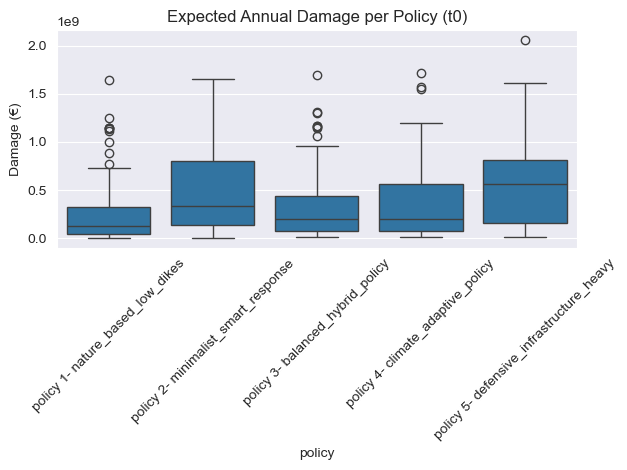

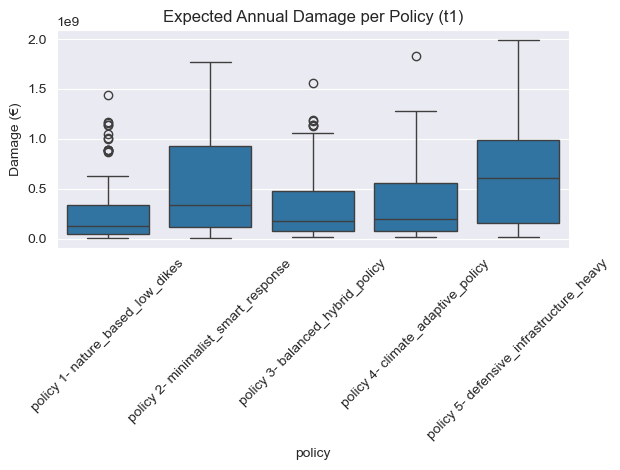

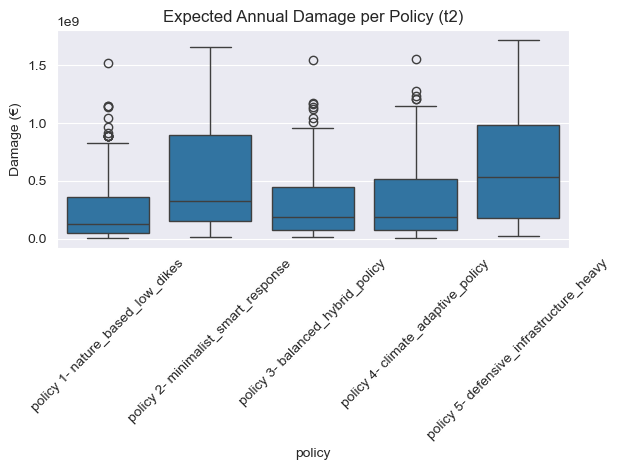

In [9]:
# Plot damage per tijdstap
for t in ["t0", "t1", "t2"]:
    plt.figure()
    sns.boxplot(data=df, x="policy", y=f"damage_{t}")
    plt.title(f"Expected Annual Damage per Policy ({t})")
    plt.ylabel("Damage (€)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/163042604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/163042604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/163042604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/163042604.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

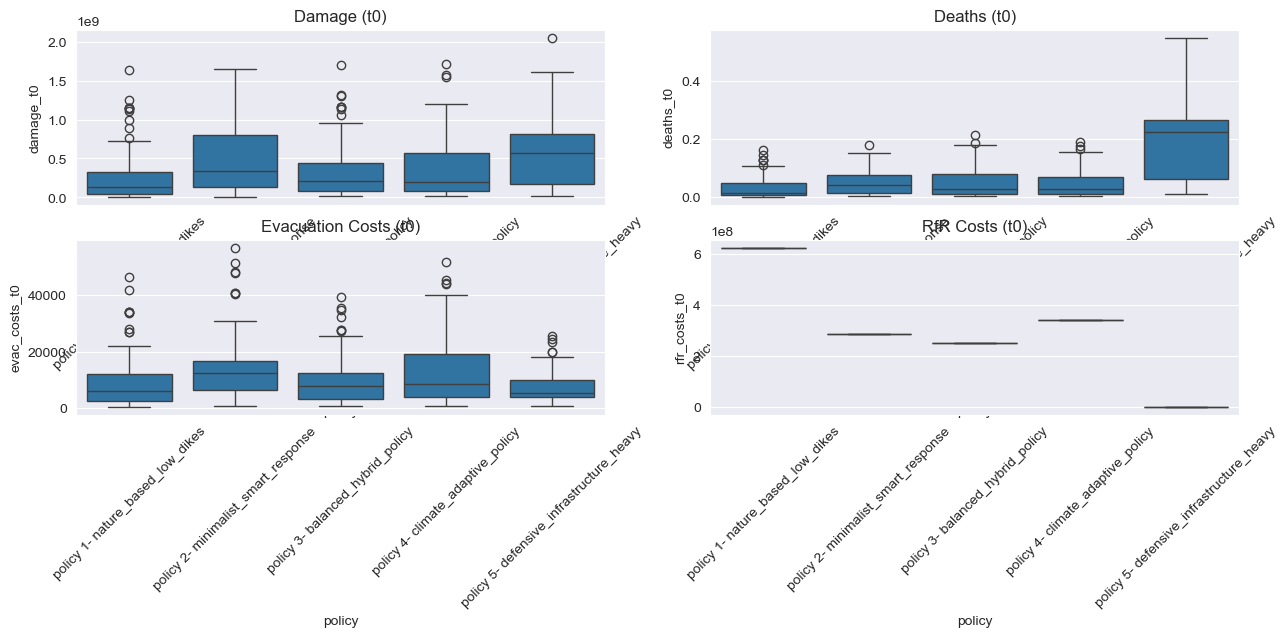

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 5))

sns.boxplot(data=df, x="policy", y="damage_t0", ax=axes[0,0])
axes[0,0].set_title("Damage (t0)")

sns.boxplot(data=df, x="policy", y="deaths_t0", ax=axes[0,1])
axes[0,1].set_title("Deaths (t0)")

sns.boxplot(data=df, x="policy", y="evac_costs_t0", ax=axes[1,0])
axes[1,0].set_title("Evacuation Costs (t0)")

sns.boxplot(data=df, x="policy", y="rfr_costs_t0", ax=axes[1,1])
axes[1,1].set_title("RfR Costs (t0)")

for row in axes:
    for ax in row:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/1456833442.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/1456833442.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/1456833442.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/1456833442.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

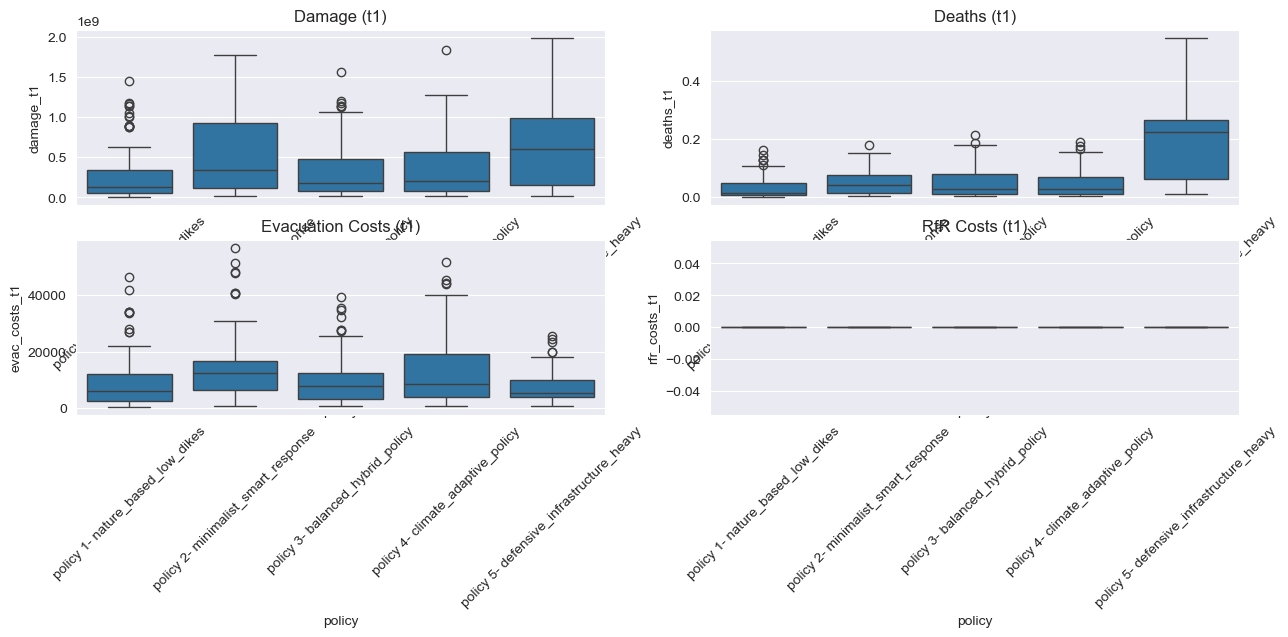

In [18]:
#Resultaten tijdstap 1

fig, axes = plt.subplots(2, 2, figsize=(15, 5))

sns.boxplot(data=df, x="policy", y="damage_t1", ax=axes[0,0])
axes[0,0].set_title("Damage (t1)")

sns.boxplot(data=df, x="policy", y="deaths_t1", ax=axes[0,1])
axes[0,1].set_title("Deaths (t1)")

sns.boxplot(data=df, x="policy", y="evac_costs_t1", ax=axes[1,0])
axes[1,0].set_title("Evacuation Costs (t1)")

sns.boxplot(data=df, x="policy", y="rfr_costs_t1", ax=axes[1,1])
axes[1,1].set_title("RfR Costs (t1)")

for row in axes:
    for ax in row:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/697448370.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/697448370.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/697448370.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b_/nlpf2cxd39n843m6xybwrynh0000gn/T/ipykernel_52513/697448370.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

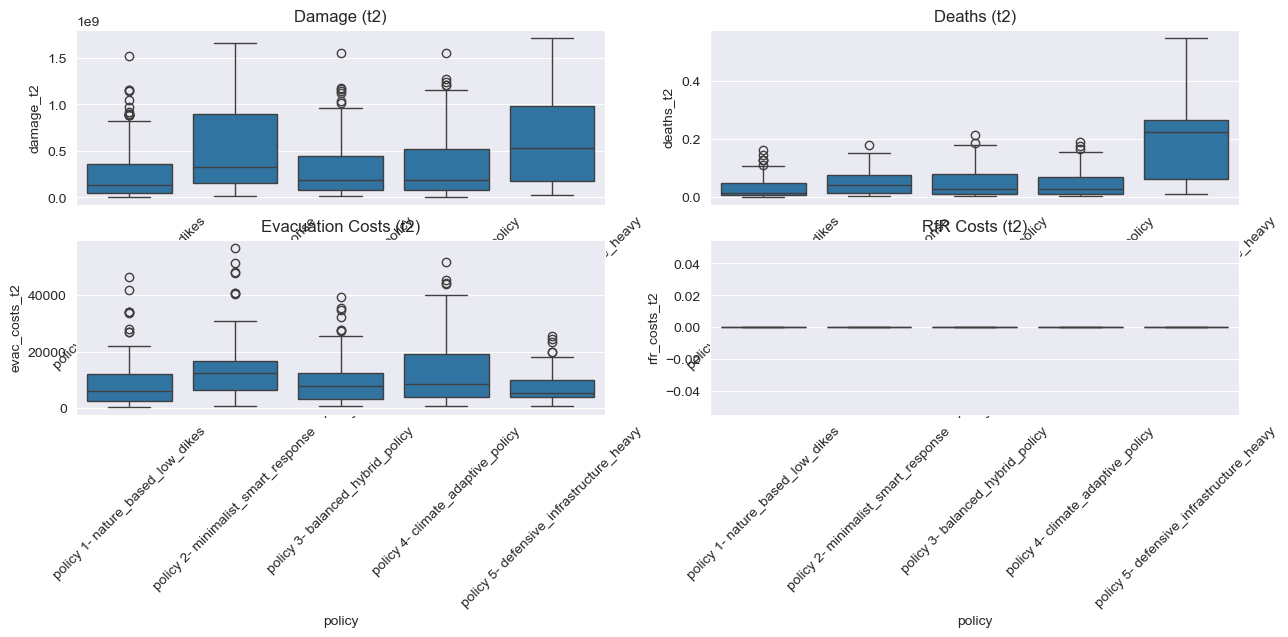

In [19]:
#Resultaten tijdstap 2

fig, axes = plt.subplots(2, 2, figsize=(15, 5))

sns.boxplot(data=df, x="policy", y="damage_t2", ax=axes[0,0])
axes[0,0].set_title("Damage (t2)")

sns.boxplot(data=df, x="policy", y="deaths_t2", ax=axes[0,1])
axes[0,1].set_title("Deaths (t2)")

sns.boxplot(data=df, x="policy", y="evac_costs_t2", ax=axes[1,0])
axes[1,0].set_title("Evacuation Costs (t2)")

sns.boxplot(data=df, x="policy", y="rfr_costs_t2", ax=axes[1,1])
axes[1,1].set_title("RfR Costs (t2)")

for row in axes:
    for ax in row:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [20]:
#Vergelijken nature based policy (die van ons) vs high flooding protection (dijken)

policies = [
    #Policy 1:
    #Activates all RfR projects early
    #Minimal dike heightening
    # Moderate early warning: proactive but not alarmist
    # Why it fits Veluwe:
        # Maximum ecological value
        # Slows discharge and improves water retention
        # Avoids heavy infrastructure
    Policy("policy 1- nature_based_low_dikes",**dict(
            get_do_nothing_dict(),
            ** { "1_RfR 0": 1,
    "2_RfR 0": 1,
    "3_RfR 0": 1,
    "4_RfR 0": 1,
    "5_RfR 0": 1,
    "Deventer_DikeIncrease 0": 2,
    "Zutphen_DikeIncrease 0": 1,
    "EWS_DaysToThreat": 3})),
    #Policy 5 - doesn't fit the veluwe
    #Maximal dike reinforcement
    #No RfR investment
    #Late early warning (reactive strategy)
    #Why it doesn’t fit Veluwe:
        # Hard infrastructure only — no ecological value
        # No focus on water retention or quality
        # Useful for comparison, not as a preferred policy
    Policy("policy 5- defensive_infrastructure_heavy",**dict(
            get_do_nothing_dict(),
            **  {
    "1_RfR 0": 0, "2_RfR 0": 0, "3_RfR 0": 0, "4_RfR 0": 0, "5_RfR 0": 0,
    "Deventer_DikeIncrease 0": 10,
    "Zutphen_DikeIncrease 0": 10,
    "EWS_DaysToThreat": 1
}))
]

In [21]:
n_scenarios = 100
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

100%|████████████████████████████████████████| 200/200 [00:08<00:00, 22.95it/s]


In [25]:
experiments, outcomes = results

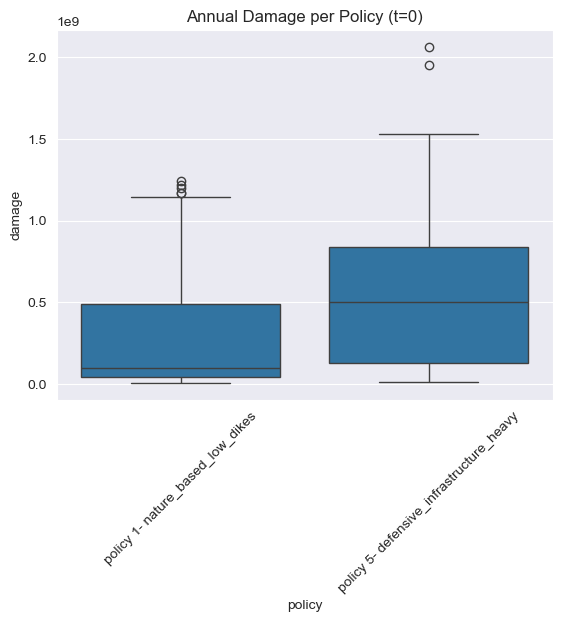

In [26]:
df = pd.DataFrame(experiments)
df["damage"] = outcomes["Expected Annual Damage"][:, 0]

sns.boxplot(data=df, x="policy", y="damage")
plt.title("Annual Damage per Policy (t=0)")
plt.xticks(rotation=45)
plt.show()

/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/tessahuysinga/Downloads/anaconda3/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{1.5, 3.5, 4.5}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]


coverage     0.257353
density      1.000000
id          11.000000
k           35.000000
mass         0.175000
mean         1.000000
n           35.000000
res_dim      7.000000
Name: 11, dtype: float64

                          box 11                                     
                             min              max  qp value  qp value
1_RfR 0                      0.0              0.0       NaN  0.000004
A.1_pfail               0.001947         0.947968       NaN  0.393219
A.1_Bmax               87.119895       334.901276  0.084448  1.000000
A.5_Bmax               49.333334       347.153562  0.373073       NaN
discount rate 1  {1.5, 3.5, 4.5}  {1.5, 3.5, 4.5}  0.463355       NaN
A.1_Brate            {1.5, 10.0}      {1.5, 10.0}  0.478610       NaN
A.3_Bmax               42.874818       347.594907  1.000000       NaN



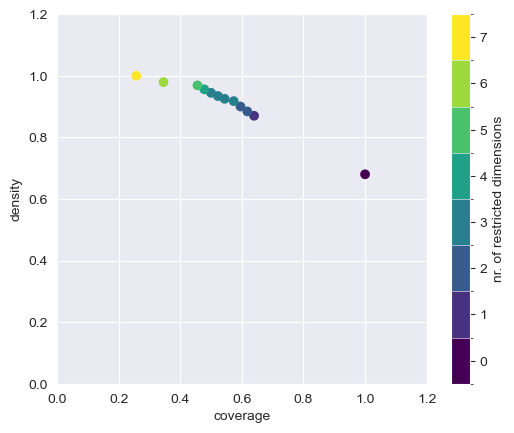

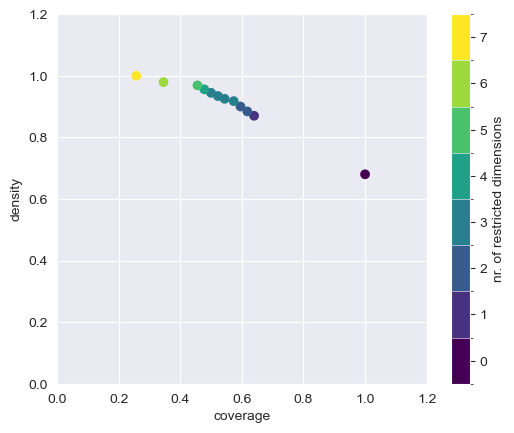

In [27]:
y = outcomes["Expected Annual Damage"][:, 0] > 1e8  # Hoge schade
prim_alg = prim.Prim(experiments, y, threshold=0.8)
box = prim_alg.find_box()
box.inspect()
box.show_tradeoff()